In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr
import copy
import os
import sys
sys.path.append(os.path.realpath('../split-data/'))
import return_period_tools as tools
import metrics
import random
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
font = {'family' : 'sans-serif','size'   : 6}
mpl.rc('font', **font)
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['lines.markersize'] = 1.5
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["grid.color"] = "#dddddd"
mpl.rcParams["grid.linewidth"] = 0.5
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
#Utility function to create a matplotlib figure with cm sizes

def cm2inch(width: float, height: float) -> tuple:
    """Converts figure size from centimeters to inch.
    
    Parameters
    ----------
    width : float
        Width of figure in centimeters
    height : float
        Height of figure in centimeters
    
    Returns
    -------
    Tuple[float, float]
        Tuple containing width and height in inches
    """
    inch = 2.54
    return (width / inch, height / inch)

In [3]:
xr.__version__

'0.16.1'

In [4]:
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [5]:
# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [6]:
#-------------------------------------------------------------------------------------------------
frequency_analysis_dict_time_split2 = 'frequency_analysis_dict_time_split2_nldas.pkl'
peak_annual_flows_dict_time_split2 = 'peak_annual_flows_dict_time_split2_nldas.pkl'
frequency_analysis_dict_return_period_split = 'frequency_analysis_dict_return_period_split_nldas.pkl'
peak_annual_flows_dict_return_period_split = 'peak_annual_flows_dict_return_period_split_nldas.pkl'
#-------------------------------------------------------------------------------------------------
analysis_dict_all={}
peak_flows_dict={}
load_data=True
if load_data:
    with open(frequency_analysis_dict_time_split2, 'rb') as fb:
        analysis_dict_all['time_split2'] = pkl.load(fb)
    with open(peak_annual_flows_dict_time_split2, 'rb') as fb:
        peak_flows_dict['time_split2'] = pkl.load(fb)
    with open(frequency_analysis_dict_return_period_split, 'rb') as fb:
        analysis_dict_all['return_period_split'] = pkl.load(fb)
    with open(peak_annual_flows_dict_return_period_split, 'rb') as fb:
        peak_flows_dict['return_period_split'] = pkl.load(fb)

In [7]:
basin_list = list(analysis_dict_all['return_period_split'].keys())

In [8]:
#-------------------------------------------------------------------------------------------------
# Set up lists to use in loops
models = ['nwm', 'lstm', 'mc', 'sac']
flows = ['nwm', 'lstm', 'mc', 'sac', 'obs']
models_obs_ri = ['nwm', 'lstm', 'mc', 'sac', 'obs', 'ri']
models_ri = ['nwm', 'lstm', 'mc', 'sac', 'ri']
#-------------------------------------------------------------------------------------------------

all_metrics = ['NSE','MSE','RMSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing',
               'beta-abs', 'peakQ', 'peakRI', 'peakT', 'peakQ-perc', 'peakRI-perc', 'peakT-abs']

In [9]:
analysis_dict={}

analysis_dict['time_split2'] = {metric:{model:[] for model in models_ri} for metric in all_metrics}
analysis_dict['return_period_split'] = {metric:{model:[] for model in models_ri} for metric in all_metrics}

for ib, basin_0str in enumerate(list(analysis_dict_all['return_period_split'].keys())):
    for metric in all_metrics:
        for model in models_ri:
            analysis_dict['return_period_split'][metric][model].extend(analysis_dict_all['return_period_split'][basin_0str][metric][model])

for ib, basin_0str in enumerate(list(analysis_dict_all['time_split2'].keys())):
    for metric in all_metrics:
        for model in models_ri:
            analysis_dict['time_split2'][metric][model].extend(analysis_dict_all['time_split2'][basin_0str][metric][model])

In [10]:
ylimz_bar = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,0.6], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
xlimz_freq = {'NSE':[-1,1], 'MSE':[0,1], 'RMSE':[0,0.7], 'KGE':[-1,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.4,0.1], 'FHV':[-60,60], 'FMS':[0,-60],'FLV':[-25,25], 'Peak-Timing':[-1,1],
          'beta-abs':[0,0.4], 'peakQ':[-20000, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,1], 'peakRI-perc':[0,1.3], 'peakT-abs':[0,2.2]}
namz = {'NSE':'Nash–Sutcliffe efficiency', 'MSE':'Mean squared error', 'RMSE':'Root mean squared error', 
        'KGE':'Kling-Gupta efficiency', 'Alpha-NSE':'Alpha-NSE: Flow variance', 'Pearson-r':'Pearson-r', 
         'Beta-NSE':'Beta-NSE: Volume bias', 'FHV':'FHV: Top 2 % peak flow bias', 
         'FMS':'FMS: Bias of FDC midsegment slope','FLV':'FLV: 30 % low flow bias', 
         'Peak-Timing':'Peak-Timing error','beta-abs':'Absolute volume bias', 'peakQ':'Peak flow error', 
         'peakRI':'Peak recurrence interval error', 'peakT':'Timing error of peak flow', 
         'peakQ-perc':'Abs. percent error of peak flow', 'peakRI-perc':'Abs. percent error of recurrence', 
         'peakT-abs':'Absolute timing error of peak flow'}
legend_locz = {'NSE':'upper right', 'MSE':'upper left', 'RMSE':'upper left', 
        'KGE':'upper right', 'Alpha-NSE':'lower right', 'Pearson-r':'lower right', 
         'Beta-NSE':'lower left', 'FHV':'lower left', 'FMS':'lower right','FLV':'upper right', 
         'Peak-Timing':'upper right','beta-abs':'upper right', 'peakQ':'lower left', 
         'peakRI':'lower left', 'peakT':'lower left', 
         'peakQ-perc':'upper left', 'peakRI-perc':'upper left', 'peakT-abs':'upper center'}
colz = {'NSE':2, 'MSE':1, 'RMSE':1, 'KGE':2, 'Alpha-NSE':2, 'Pearson-r':1, 
         'Beta-NSE':1, 'FHV':1, 'FMS':1,'FLV':2, 'Peak-Timing':1,
          'beta-abs':2, 'peakQ':1, 'peakRI':1, 'peakT':1, 
          'peakQ-perc':1, 'peakRI-perc':1, 'peakT-abs':1}

In [11]:
model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
model_name_list = ['lstm', 'mc', 'sac', 'nwm']
model_colors = ['b', 'orange', 'red', 'red']
model_style = ['-', '-', '-', '--']
model_name_label_dict = {model_name:model_label for model_name, model_label in \
                         zip(model_name_list,model_label_list)}
model_ri_list = ['ri', 'lstm', 'mc', 'sac', 'nwm']
train_types = ['time_split2','return_period_split']

base_metrics = metrics.get_available_metrics()

In [12]:
plot_metrics = ['NSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing']
ppm = {'NSE':'NSE','KGE':'KGE','Alpha-NSE':'Alpha-NSE',
       'Pearson-r':'Pearson-r','Beta-NSE':'Beta-NSE',
       'FHV':'FHV','FMS':'FMS','FLV':'FLV','peakT-abs':'Peak-Timing'}

Nash–Sutcliffe efficiency
                      LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n (n=5969)   0.682858  0.682708  0.574540  0.555242   6920
5-25 \n (n=1260)  0.758856  0.749823  0.657096  0.668837   1500
25-50 \n (n=185)  0.764236  0.727460  0.633909  0.713099    210
50-100 \n (n=91)  0.784231  0.748131  0.627079  0.741209    108
100+ \n (n=84)    0.727783  0.658999  0.553966  0.672599     97
                      LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n (n=5969)   0.842283  0.762675  0.655904  0.553421   6900
5-25 \n (n=1260)  0.867352  0.808291  0.698650  0.668672   1487
25-50 \n (n=185)  0.778492  0.761996  0.617210  0.712623    205
50-100 \n (n=91)  0.791842  0.761853  0.628695  0.741209    106
100+ \n (n=84)    0.736164  0.691083  0.550990  0.669049     96


/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:143: UserWarning: FixedFormatter should only be used together with FixedLocator


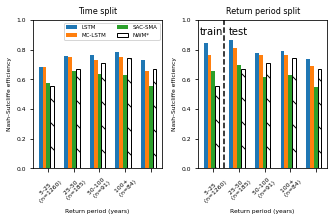

Abs. percent error of peak flow
                      LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n (n=5969)   0.283669  0.282471  0.315314  0.314965   6920
5-25 \n (n=1260)  0.303181  0.316800  0.440264  0.341139   1500
25-50 \n (n=185)  0.314600  0.425075  0.541265  0.366050    210
50-100 \n (n=91)  0.323679  0.396175  0.577682  0.394460    108
100+ \n (n=84)    0.387294  0.525513  0.650026  0.512890     97
                      LSTM   MC-LSTM   SAC-SMA      NWM*  count
1-5 \n (n=5969)   0.150202  0.220831  0.298944  0.314864   6900
5-25 \n (n=1260)  0.168977  0.287331  0.450909  0.340445   1487
25-50 \n (n=185)  0.398098  0.427239  0.565175  0.368957    205
50-100 \n (n=91)  0.415035  0.428081  0.564232  0.394460    106
100+ \n (n=84)    0.433651  0.509316  0.676378  0.513896     96


/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:143: UserWarning: FixedFormatter should only be used together with FixedLocator


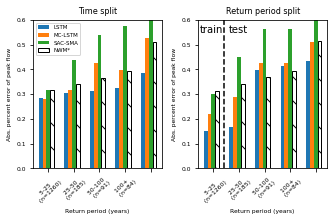

In [20]:
model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
model_name_list = ['lstm', 'mc', 'sac', 'nwm']
model_name_label_dict = {model_name:model_label for model_name, model_label in \
                         zip(model_name_list,model_label_list)}
model_ri_list = ['ri', 'lstm', 'mc', 'sac', 'nwm']
train_types = ['time_split2','return_period_split']
text_locs = {'NSE':[[-0.55, 0.9],[0.6, 0.9]], 'peakQ-perc':[[-0.55, 0.55],[0.6, 0.55]]}

ri_list = {}
ri_bins = {}
count_missing = {train_type:{} for train_type in train_types}
#for metric in all_metrics:
for metric in  ['NSE', 'peakQ-perc']:
    print(namz[metric])
    bin_max=[5, 25,50,100,1000000000]
    bin_names=['1-5 \n (n=5969)', '5-25 \n (n=1260)','25-50 \n (n=185)','50-100 \n (n=91)','100+ \n (n=84)']
    ri_list[metric] = {train_type:{model_label:{bin_name:[] for bin_name in bin_names} for \
                           model_label in model_label_list} for train_type in train_types}
    ri_bins[metric] = {train_type:{model_label:{bin_name:0 for bin_name in bin_names} for \
                           model_label in model_label_list} for train_type in train_types}
    for train_type in train_types:
        ri_bins[metric][train_type]['count'] = {bin_name:0 for bin_name in bin_names}
    
    count_missing['time_split2'][metric] = {model_ri:0 for model_ri in model_ri_list}
    for i, ri in enumerate(analysis_dict['time_split2'][metric]['ri']):
        if analysis_dict['time_split2'][metric]['ri'][i] is None:
            continue
        
        skip_this=False
        for icheck in model_ri_list:
            if analysis_dict['time_split2'][metric][icheck][i] is None:
                skip_this=True
                count_missing['time_split2'][metric][icheck]+=1
            if np.isinf(analysis_dict['time_split2'][metric][icheck][i]):
                skip_this=True
                count_missing['time_split2'][metric][icheck]+=1
            if isinstance(analysis_dict['time_split2'][metric][icheck][i], str):
                skip_this=True
                count_missing['time_split2'][metric][icheck]+=1
            if analysis_dict['time_split2'][metric][icheck][i] != analysis_dict['time_split2'][metric][icheck][i]:
                skip_this=True
                count_missing['time_split2'][metric][icheck]+=1

        if skip_this:
            continue
            skip_this=False

        for maxv,bin_name in zip(bin_max, bin_names):
            if ri<maxv:
                ri_bins[metric]['time_split2']['count'][bin_name]+=1
                for model_name, model_label in zip(model_name_list, model_label_list):
                    ri_list[metric]['time_split2'][model_label][bin_name].append( \
                                                    analysis_dict['time_split2'][metric][model_name][i])
                break
                
    count_missing['return_period_split'][metric] = {model_ri:0 for model_ri in model_ri_list}
    for i, ri in enumerate(analysis_dict['return_period_split'][metric]['ri']):
        if analysis_dict['return_period_split'][metric]['ri'][i] is None:
            continue
        
        skip_this=False
        for icheck in model_ri_list:
            if analysis_dict['return_period_split'][metric][icheck][i] is None:
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1
            if np.isinf(analysis_dict['return_period_split'][metric][icheck][i]):
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1
            if isinstance(analysis_dict['return_period_split'][metric][icheck][i], str):
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1
            if analysis_dict['return_period_split'][metric][icheck][i] != analysis_dict['return_period_split'][metric][icheck][i]:
                skip_this=True
                count_missing['return_period_split'][metric][icheck]+=1

        if skip_this:
            continue
            skip_this=False

        for maxv,bin_name in zip(bin_max, bin_names):
            if ri<maxv:
                ri_bins[metric]['return_period_split']['count'][bin_name]+=1
                for model_name, model_label in zip(model_name_list, model_label_list):
                    ri_list[metric]['return_period_split'][model_label][bin_name].append( \
                                                        analysis_dict['return_period_split'][metric][model_name][i])
                break
                                
                
    for maxv,bin_name in zip(bin_max, bin_names):
        if ri_bins[metric]['time_split2']['count'][bin_name] < 1:
            continue
        for model_label in model_label_list:
            if metric == 'peakT-abs':
                ri_bins[metric]['time_split2'][model_label][bin_name] = np.nanmean( \
                                                            ri_list[metric]['time_split2'][model_label][bin_name])            
            else:
                ri_bins[metric]['time_split2'][model_label][bin_name] = np.nanmedian( \
                                                            ri_list[metric]['time_split2'][model_label][bin_name])
        if ri_bins[metric]['return_period_split']['count'][bin_name] < 1:
            continue
        for model_label in model_label_list:
            if metric == 'Peak-Timing':
                ri_bins[metric]['return_period_split'][model_label][bin_name] = np.nanmean( \
                                                            ri_list[metric]['return_period_split'][model_label][bin_name])            
            else:
                ri_bins[metric]['return_period_split'][model_label][bin_name] = np.nanmedian( \
                                                            ri_list[metric]['return_period_split'][model_label][bin_name])

    fig = plt.figure(figsize=cm2inch(12,8))
    print(pd.DataFrame(ri_bins[metric]['time_split2']))
    ax = fig.add_subplot(1, 2, 1)    
    plt_df = pd.DataFrame(ri_bins[metric]['time_split2'])[model_label_list]
    x = np.arange(len(list(plt_df.index.values)))  # the label locations
    width = 0.15  # the width of the bars
    bar1 = ax.bar(x - 2*width, plt_df.loc[:,'LSTM'], width, label='LSTM')
    bar2 = ax.bar(x - width, plt_df.loc[:,'MC-LSTM'], width, label='MC-LSTM')
    bar3 = ax.bar(x, plt_df.loc[:,'SAC-SMA'], width, label='SAC-SMA')
    bar4 = ax.bar(x + width, plt_df.loc[:,'NWM*'], width, label='NWM*', 
                  hatch="\\", color='white', edgecolor='black')
    ax.set_ylabel(namz[metric])
    ax.set_xlabel('Return period (years)')
    ax.set_xticklabels(bin_names, rotation = 45)
    ax.set_ylim(ylimz_bar[metric])
    ax.legend(loc=legend_locz[metric], ncol=colz[metric], fontsize=5.5)
    ax.set_title('Time split')
    
    print(pd.DataFrame(ri_bins[metric]['return_period_split']))
    ax = fig.add_subplot(1, 2, 2)
    ax.axvline(x=0.4, color='k', linestyle='--')
    ax.text(text_locs[metric][0][0], text_locs[metric][0][1], 'train')
    ax.text(text_locs[metric][1][0], text_locs[metric][1][1], 'test')

    plt_df = pd.DataFrame(ri_bins[metric]['return_period_split'])[model_label_list]
    x = np.arange(len(list(plt_df.index.values)))  # the label locations
    width = 0.15  # the width of the bars
    bar1 = ax.bar(x - 2*width, plt_df.loc[:,'LSTM'], width, label='LSTM')
    bar2 = ax.bar(x - width, plt_df.loc[:,'MC-LSTM'], width, label='MC-LSTM')
    bar3 = ax.bar(x, plt_df.loc[:,'SAC-SMA'], width, label='SAC-SMA')
    bar4 = ax.bar(x + width, plt_df.loc[:,'NWM*'], width, label='NWM*', 
                  hatch="\\", color='white', edgecolor='black')
    ax.set_ylabel(namz[metric])
    ax.set_xlabel('Return period (years)')
    ax.set_xticklabels(bin_names, rotation = 45)
    ax.set_ylim(ylimz_bar[metric])
#    ax.legend(loc=legend_locz[metric], ncol=colz[metric], fontsize=5.5)
    ax.set_title('Return period split')
            
    fig.tight_layout(pad=1.0)
    fig.savefig('../figs/bars_{}_nldas.pdf'.format(metric), dpi=600)
    fig.savefig('../figs/bars_{}_nldas.png'.format(metric), dpi=600)
    plt.show()
    plt.close()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


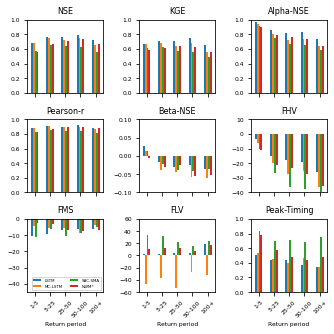

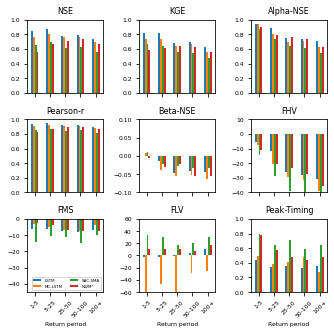

In [14]:
# Big tables for each training type

count_missing = {train_type:{} for train_type in train_types}
for train_type in train_types:
    
    fig = plt.figure(figsize=cm2inch(12,12))
    
    ri_list = {metric:{} for metric in all_metrics}
    ri_bins = {metric:{} for metric in all_metrics}
    for imetric, metric in enumerate(plot_metrics):
        bin_max=[5, 25,50,100,1000000000]
        bin_names=['1-5', '5-25','25-50','50-100','100+']
        ri_list[metric][train_type] = {model_label:{bin_name:[] for bin_name in bin_names} for \
                                       model_label in model_label_list}
        ri_bins[metric][train_type] = {model_label:{bin_name:[] for bin_name in bin_names} for \
                                       model_label in model_label_list}

        ri_bins[metric][train_type]['count'] = {bin_name:0 for bin_name in bin_names}

        count_missing[train_type][metric] = {model_ri:0 for model_ri in model_ri_list}
        for i, ri in enumerate(analysis_dict[train_type][metric]['ri']):
            if analysis_dict[train_type][metric]['ri'][i] is None:
                continue

            skip_this=False
            for icheck in model_ri_list:
                if analysis_dict[train_type][metric][icheck][i] is None:
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1
                if np.isinf(analysis_dict[train_type][metric][icheck][i]):
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1
                if isinstance(analysis_dict[train_type][metric][icheck][i], str):
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1
                if analysis_dict[train_type][metric][icheck][i] != \
                                     analysis_dict[train_type][metric][icheck][i]:
                    skip_this=True
                    count_missing[train_type][metric][icheck]+=1

            if skip_this:
                continue
                skip_this=False

            for maxv,bin_name in zip(bin_max, bin_names):
                if ri<maxv:
                    ri_bins[metric][train_type]['count'][bin_name]+=1
                    for model_name, model_label in zip(model_name_list, model_label_list):
                        ri_list[metric][train_type][model_label][bin_name].append( \
                                                        analysis_dict[train_type][metric][model_name][i])
                    break


        for maxv,bin_name in zip(bin_max, bin_names):
            if ri_bins[metric][train_type]['count'][bin_name] < 1:
                continue
            for model_label in model_label_list:
                if metric in ['Peak-Timing', 'peakT-abs']:
                    ri_bins[metric][train_type][model_label][bin_name] = np.nanmean( \
                                                ri_list[metric][train_type][model_label][bin_name])
                else:
                    ri_bins[metric][train_type][model_label][bin_name] = np.nanmedian( \
                                                ri_list[metric][train_type][model_label][bin_name])
                
        ax = fig.add_subplot(3, 3, imetric+1)    
        pd.DataFrame(ri_bins[metric][train_type])[model_label_list].plot.bar(ax=ax)

        if imetric+1 in [7,8,9]:
            ax.set_xticklabels(bin_names, rotation = 45)
            ax.set_xlabel("Return period")
        else:
            ax.set_xticklabels([])

        ax.set_title(metric)
        ax.set_ylim(ylimz_bar[metric])
        if metric =='FMS':
            ax.legend(fontsize=4, ncol=2, loc='lower right')
        else:
            ax.get_legend().remove()

            
    fig.tight_layout(pad=1)
    fig.savefig('../figs/bars_{}_training_nldas.pdf'.format(train_type), dpi=600)
    fig.savefig('../figs/bars_{}_training_nldas.png'.format(train_type), dpi=600)
    plt.show()
    plt.close()

In [15]:
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb:
    nwm_results = pkl.load(fb)
    
with open('./model_output_for_analysis/lstm_time_split2_nldas.p', 'rb') as fb:
    lstm_results_time_split2 = pkl.load(fb)
with open('./model_output_for_analysis/mclstm_time_split2_nldas.p', 'rb') as fb:
    mclstm_results_time_split2 = pkl.load(fb)
with open('./model_output_for_analysis/sacsma_time_split2_nldas.p', 'rb') as fb:
    sacsma_results_time_split2 = pkl.load(fb)

In [17]:
forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2/basin_mean_forcing/nldas_all_basins_in_one_directory/'

total_mass_error = {'absolute':{flow:[] for flow in flows}, 
              'positive':{flow:[] for flow in flows}, 
              'negative':{flow:[] for flow in flows}}

total_mass = {}

cumulative_mass_all = {}

labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}

start_date = pd.Timestamp('1996-10-01')
end_date = pd.Timestamp('2014-01-01')

plot_cum_mass = False

first_basin = True

read_values = True
if read_values:
    with open('total_mass_error_nldas.pkl', 'rb') as fb:
        total_mass_error = pkl.load(fb)
    with open('total_mass_nldas.pkl', 'rb') as fb:
        total_mass = pkl.load(fb)
    with open('cumulative_mass_all_nldas.pkl', 'rb') as fb: 
        cumulative_mass_all = pkl.load(fb)
else:
    for basin_0str in list(analysis_dict_all['return_period_split'].keys()):
        basin_int = int(basin_0str)
        print(basin_0str)

        #-------------------------------------------------------------------------------------------------
        # Reset the total mass to zero for this basin    
        cumulative_mass = {flow:[0] for flow in flows}
        cumulative_mass['precip'] = [0]
        total_mass[basin_0str] = {flow:0 for flow in flows}
        imass=1
        #-------------------------------------------------------------------------------------------------


        #-------------------------------------------------------------------------------------------------
        # We need the basin area to convert to CFS, to interpolate the RI from LPIII
        basin_area = pd_attributes.loc[basin_int, 'area_geospa_fabric']
        basin_str = tools.gauge_id_str(basin_int)
        #-------------------------------------------------------------------------------------------------

        #-------------------------------------------------------------------------------------------------
        # Make dictionary with all the flows
        flow_mm = {}    
        #-------------------------------------------------------------------------------------------------
        # Get the NWM data for this basin in an xarray dataset.
        xr_nwm = xr.DataArray(nwm_results[basin_0str]['streamflow'].values, 
                 coords=[nwm_results[basin_0str]['streamflow'].index], 
                 dims=['datetime'])
        # convert from CFS to mm/day
        # fm3/s * 3600 sec/hour * 24 hour/day / (m2 * mm/m)
        flow_mm['nwm'] = xr_nwm.loc[start_date:end_date]*3600*24/(basin_area*1000)
        #-------------------------------------------------------------------------------------------------
        # Standard LSTM 
        xrr = lstm_results_time_split2[basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
        #-------------------------------------------------------------------------------------------------
        # Mass-conserving LSTM data trained on all years
        xrr = mclstm_results_time_split2[basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
        #-------------------------------------------------------------------------------------------------
        # SACSMA Mean
        df = sacsma_results_time_split2[basin_0str].loc[start_date:end_date]
        flow_mm['sac'] = df
        #-------------------------------------------------------------------------------------------------
        # OBSERVATIONS
        xrr = mclstm_results_time_split2[basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
        #-------------------------------------------------------------------------------------------------
        # FORCING
        forcing = pd.read_csv(forcing_dir+basin_0str+'_lump_nldas_forcing_leap.txt', delim_whitespace=True, header=3)
        forcing = forcing.iloc[6118:]
        forcing.index=pd.to_datetime((forcing.Year*10000+forcing.Mnth*100+forcing.Day).apply(str),format='%Y%m%d')
        #-------------------------------------------------------------------------------------------------

        
        #-------------------------------------------------------------------------------------------------
        # Make sure we are in a time period that all the flow members have values
        # If there is missin observations than we can't compare the mass of the observed with simulaitons
        skip_basin_because_missing_obs = False
        for d in mclstm_results_time_split2[basin_0str]['1D']['xr']['QObs(mm/d)_obs'].date:
            if d.values < start_date:
                continue
            if d.values > end_date:
                break
            if np.isnan(flow_mm['obs'].loc[d.values].values[0]):
                skip_basin_because_missing_obs = True
                break
            else:
                #-------------------------------------------------------------------------------------------------
                # Keep track of the cumulative mass and add it to the list
                cumulative_mass['precip'].append(forcing['PRCP(mm/day)'].loc[d.values] + \
                                                 cumulative_mass['precip'][imass-1])

                cumulative_mass['obs'].append(flow_mm['obs'].loc[d.values].values[0] + \
                                              cumulative_mass['obs'][imass-1])

                cumulative_mass['nwm'].append(flow_mm['nwm'].loc[d.values].values + \
                                              cumulative_mass['nwm'][imass-1])

                cumulative_mass['lstm'].append(flow_mm['lstm'].loc[d.values].values[0] + \
                                               cumulative_mass['lstm'][imass-1])

                cumulative_mass['mc'].append(flow_mm['mc'].loc[d.values].values[0] + \
                                             cumulative_mass['mc'][imass-1])

                cumulative_mass['sac'].append(flow_mm['sac'].loc[d.values] + \
                                              cumulative_mass['sac'][imass-1])
                imass+=1
                #-------------------------------------------------------------------------------------------------

        #-------------------------------------------------------------------------------------------------
        # If there is missin observations than we can't compare the mass of the observed with simulaitons            
        if skip_basin_because_missing_obs:
            print("skipping basin {} because of missing observations".format(basin_0str))
            continue

            
        for flow in flows:
            total_mass[basin_0str][flow] = np.nansum(flow_mm[flow].loc[start_date:end_date])

        for flow in flows:
            total_mass_error['absolute'][flow].append(np.abs(total_mass[basin_0str][flow] - \
                                                             total_mass[basin_0str]['obs'])/ \
                                                             total_mass[basin_0str]['obs'])
            if (total_mass[basin_0str][flow] - total_mass[basin_0str]['obs']) > 0:
                total_mass_error['positive'][flow].append((total_mass[basin_0str][flow] - \
                                                           total_mass[basin_0str]['obs'])/ \
                                                           total_mass[basin_0str]['obs'])
                total_mass_error['negative'][flow].append(0)
            else:
                total_mass_error['negative'][flow].append((total_mass[basin_0str][flow] - \
                                                           total_mass[basin_0str]['obs']) / \
                                                           total_mass[basin_0str]['obs'])
                total_mass_error['positive'][flow].append(0)
                    
        # _______________________________________________________________________
        # Keep track of all the cumulative mass through time for each basin
        if first_basin and not skip_basin_because_missing_obs:
            for flow in flows:
                cumulative_mass_all[flow] = np.array(cumulative_mass[flow])
            cumulative_mass_all['precip'] = np.array(cumulative_mass['precip'])
            first_basin = False
        if  not skip_basin_because_missing_obs and not first_basin:
            for flow in flows:
                cumulative_mass_all[flow] += np.array(cumulative_mass[flow])
            cumulative_mass_all['precip'] +=np.array(cumulative_mass['precip'])
                    
        if plot_cum_mass:
            fig = plt.figure(figsize=cm2inch(8.3,8))
            for flow in flows:
                plt.plot(cumulative_mass[flow], label=labelz[flow])
            plt.plot(cumulative_mass['precip'], label='Precipitation')
            plt.legend()
            plt.title(basin_0str)
            plt.ylabel('total water [mm]')
            plt.xlabel('simulation time (days)')
            fig.tight_layout()
            plt.show()
            plt.close()
            
dump_values = True
if dump_values:
    with open('total_mass_error_nldas.pkl', 'wb') as fb:
        pkl.dump(total_mass_error, fb)
    with open('total_mass_nldas.pkl', 'wb') as fb:
        pkl.dump(total_mass, fb)
    with open('cumulative_mass_all_nldas.pkl', 'wb') as fb:
        pkl.dump(cumulative_mass_all, fb)


In [19]:
total_mass_error_dict = {}
for iplot, error_type in enumerate(['absolute', 'positive', 'negative']):
    print("error type: ", error_type)
    error_means = {}
    for tme_key in ['lstm', 'mc', 'sac', 'nwm']:
        print(tme_key)
        print('mean, median, max, min')
        print(np.round(np.mean(total_mass_error[error_type][tme_key]),4), 
              np.round(np.median(total_mass_error[error_type][tme_key]),4),
              np.round(np.max(total_mass_error[error_type][tme_key]),4),
              np.round(np.min(total_mass_error[error_type][tme_key]),4))
        error_means[tme_key] = np.round(np.mean(total_mass_error[error_type][tme_key]),4)
    total_mass_error_dict[error_type] = error_means

error type:  absolute
lstm
mean, median, max, min
0.1426 0.104 1.5041 0.0009
mc
mean, median, max, min
0.1383 0.0976 1.0764 0.0005
sac
mean, median, max, min
0.1669 0.1279 1.264 0.0003
nwm
mean, median, max, min
0.2032 0.1256 11.8109 0.0001
error type:  positive
lstm
mean, median, max, min
0.0927 0.021 1.5041 0.0
mc
mean, median, max, min
0.0691 0.0 1.0764 0.0
sac
mean, median, max, min
0.0929 0.0 1.264 0.0
nwm
mean, median, max, min
0.111 0.0 11.8109 0.0
error type:  negative
lstm
mean, median, max, min
-0.0499 0.0 0.0 -0.533
mc
mean, median, max, min
-0.0692 -0.023 0.0 -0.7623
sac
mean, median, max, min
-0.074 -0.0043 0.0 -0.6914
nwm
mean, median, max, min
-0.0922 -0.0206 0.0 -0.8764


In [42]:
total_mass_error_dict

{'absolute': {'lstm': 0.1426, 'mc': 0.1383, 'sac': 0.1669, 'nwm': 0.2032},
 'positive': {'lstm': 0.0927, 'mc': 0.0691, 'sac': 0.0929, 'nwm': 0.111},
 'negative': {'lstm': -0.0499, 'mc': -0.0692, 'sac': -0.074, 'nwm': -0.0922}}

In [20]:
error_plot_df = pd.DataFrame(total_mass_error_dict).transpose()
error_plot_df = error_plot_df.rename(columns={'lstm':'LSTM', 'mc':'MC-LSTM', 'sac':'SAC-SMA', 'nwm':'NWM*'})

In [21]:
# Set up lists to use in loops
models = ['lstm', 'mc', 'sac', 'nwm']
flows = ['lstm', 'mc', 'sac', 'nwm', 'obs']
models_obs_ri = ['lstm', 'mc', 'sac', 'nwm', 'obs', 'ri']
models_ri = ['lstm', 'mc', 'sac', 'nwm', 'ri']

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


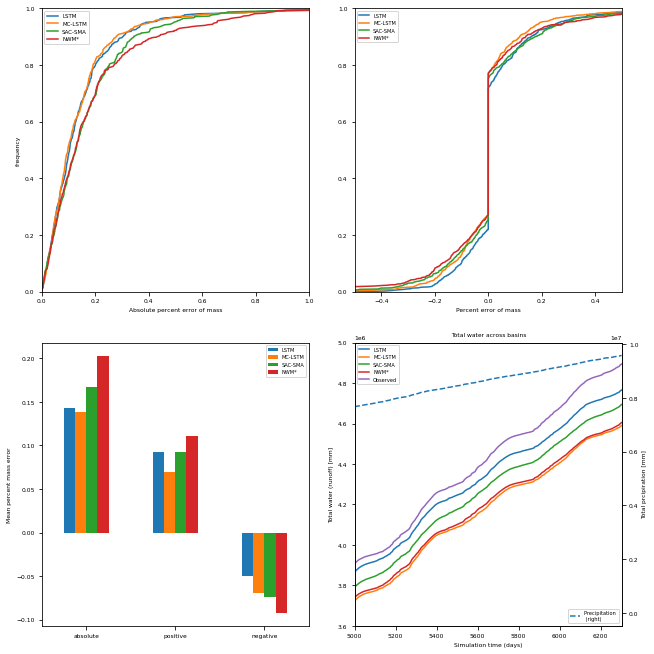

In [22]:
fig = plt.figure(figsize=cm2inch(24,24))
limz = {'absolute':([0,1],[0,1]), 'positive':([0,1],[0,1]), 
        'negative':([0,-1],[0,0.6]), 'neg-pos':([-.5,.5],[0,1])}
xlabz = {'absolute':'Absolute percent error of mass', 
         'positive':'Positive error of mass (percent)', 
         'negative':'Negative error of mass (percent)',
         'neg-pos':'Percent error of mass'}
yvalues={}
plotdata={}
for iplot, error_type in enumerate(['absolute', 'positive', 'negative']):

    plot_df = pd.DataFrame({model_label:total_mass_error[error_type][model_label] for model_label in models})  
    plotdata[error_type] = np.sort(plot_df[~pd.isnull(plot_df)], axis=0)
    
    if error_type == 'absolute':
        
        for model in models:
            yvalues[model] = list(range(len(total_mass_error[error_type][model])))
            for i, _ in enumerate(yvalues[model]):
                yvalues[model][i] = yvalues[model][i]/len(yvalues[model])        
        
        ax = fig.add_subplot(2, 2, 1)
        ax.plot(pd.DataFrame(data=plotdata[error_type], columns=model_label_list), 
                             yvalues[model][:len(plotdata[error_type])])
        ax.set_xlim(limz[error_type][0])
        ax.set_ylim(limz[error_type][1])
        ax.set_xlabel(xlabz[error_type])
        ax.set_ylabel("frequency")
        #plt.title("Abs. Percent Mass Error")
        plt.legend(model_label_list, fontsize=5.5)

    
combined_pos_neg_error = {}
for i, model in enumerate(models):
    combined_pos_neg_error[model] = list(np.append(plotdata['negative'][:,i], plotdata['positive'][:,i]))
plotdata2 = pd.DataFrame(combined_pos_neg_error)
    
ax = fig.add_subplot(2, 2, 2)
for model in models:
    yvalues[model] = list(range(plotdata2[model].shape[0]))
    for i, _ in enumerate(yvalues[model]):
        yvalues[model][i] = yvalues[model][i]/len(yvalues[model])
# plot_df = pd.DataFrame({model_label:combined_pos_neg_error[model] for model in models})    
plotdata['neg-pos'] = np.sort(plotdata2[~pd.isnull(plotdata2)], axis=0)
ax.plot(pd.DataFrame(data=plotdata['neg-pos'], columns=model_label_list), 
        yvalues[model][:len(plotdata['neg-pos'])])
ax.set_xlim(limz['neg-pos'][0])
ax.set_ylim(limz['neg-pos'][1])
ax.set_xlabel(xlabz['neg-pos'])
plt.legend(model_label_list)

ax = fig.add_subplot(2, 2, 4)
for flow in flows:
    ax.plot(cumulative_mass_all[flow], label=labelz[flow])
ax2 = ax.twinx()
ax2.plot(cumulative_mass_all['precip'], '--', label='Precipitation \n (right)')
ax.set_title("Total water across basins", fontsize=6)
ax.set_ylabel('Total water (runoff) [mm]')
ax2.set_ylabel('Total prcipiration [mm]', c='k')
ax.set_xlabel('Simulation time (days)')
ax.set_ylim([3.6e6,5e6])
ax.set_xlim([5000,len(cumulative_mass_all[flow])])
ax.legend()
ax2.legend(loc='lower right')

ax = fig.add_subplot(2, 2, 3)
error_plot_df.plot.bar(ax=ax)
ax.set_xticklabels(['absolute', 'positive', 'negative'], rotation = 0)
ax.set_ylabel("Mean percent mass error")

fig.tight_layout(pad=2.0)
fig.savefig('../figs/mass_error_frequency_nldas.pdf', dpi=600)
fig.savefig('../figs/mass_error_frequency_nldas.png', dpi=600)
plt.show()
plt.close()

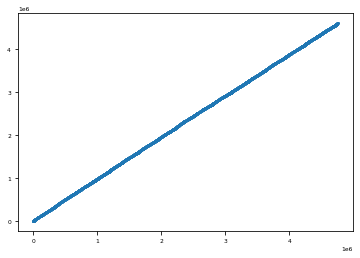

In [22]:

plt.scatter(cumulative_mass_all['lstm'], cumulative_mass_all['nwm'])

In [33]:
np.array([1,2,3])+np.array([2,3,4])

array([3, 5, 7])

In [41]:
plot_start = 0
plot_n = 50
plot_end = plot_n
for i in range(int(cumulative_mass_all[flow].shape[0]/50)-1):
    for flow in flows:
        plt.plot(cumulative_mass_all[flow][plot_start:plot_end], label=flow)
    plt.legend()
    plot_start+=plot_n
    plot_end+=plot_n
    plt.savefig('/home/jmframe/temp_mclstm_mass_figs/zplotz_{}.png'.format(i))
#    plt.show()
    plt.close()

In [37]:
int(cumulative_mass_all[flow].shape[0]/50)-1

125